In [5]:
# Importo las librerías necesarias
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import datetime
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt

import os
os.environ['PROJ_LIB'] = '/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1003/share/proj'
from mpl_toolkits.basemap import Basemap

In [6]:
# Cargo el fichero json con mis localizaciones
with open('Historial de ubicaciones.json', 'r') as fl:
    raw = json.loads(fl.read())
data = pd.DataFrame(raw['locations'])
del raw 

In [7]:
# Reviso la cantidad de datos que hay en el fichero
data.shape

(912720, 9)

In [8]:
# Conversión a las unidades habituales
data['latitudeE7'] = data['latitudeE7']/float(1e7) 
data['longitudeE7'] = data['longitudeE7']/float(1e7)
data['timestampMs'] = data['timestampMs'].map(lambda x: float(x)/1000) #to seconds
data['datetime'] = data.timestampMs.map(datetime.datetime.fromtimestamp)
# Renombrado de columnas
data.rename(columns={'latitudeE7':'latitude', 'longitudeE7':'longitude', 'timestampMs':'timestamp'}, inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
# Se crean nuevas columnas con el año, mes, fecha y hora
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['date'] = data['datetime'].dt.date
data['hour'] = data['datetime'].dt.hour

In [10]:
# Se crea una nueva columna que indique si la precisión es mayor o menor de 2000 metros
data['value_accuracy'] = np.where(data['accuracy']>=5000, '1', '0')

In [11]:
data.head()

,timestamp,latitude,longitude,accuracy,activity,altitude,verticalAccuracy,velocity,heading,datetime,year,month,date,hour,value_accuracy
0,1.422486e+09,-30.707036,-62.011502,65,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:02:56.075,2015,1,2015-01-28,20,0
1,1.422486e+09,-30.707036,-62.011511,65,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:03:56.835,2015,1,2015-01-28,20,0
2,1.422486e+09,-30.707100,-62.011320,199,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:04:56.824,2015,1,2015-01-28,20,0
3,1.422486e+09,-30.707034,-62.011510,65,"[{'timestampMs': '1422486360319', 'activity': ...",NaN,NaN,NaN,NaN,2015-01-28 20:05:57.013,2015,1,2015-01-28,20,0
4,1.422486e+09,-30.707040,-62.011499,64,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:06:57.243,2015,1,2015-01-28,20,0


In [12]:
# expantir todas las columnas que tengas listas de diccionarios 
#(GENERA UN NUEVO DATAFRAME DONDE "ACTIVITY" ESTÁ EXPLOTADA EN DISTINTAS ACTIVIDADES EL MISMO DÍA)
data_ex = data.apply(lambda x: x.explode()).reset_index(drop=True)

In [13]:
data_ex.head()

,timestamp,latitude,longitude,accuracy,activity,altitude,verticalAccuracy,velocity,heading,datetime,year,month,date,hour,value_accuracy
0,1.422486e+09,-30.707036,-62.011502,65,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:02:56.075,2015,1,2015-01-28,20,0
1,1.422486e+09,-30.707036,-62.011511,65,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:03:56.835,2015,1,2015-01-28,20,0
2,1.422486e+09,-30.707100,-62.011320,199,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:04:56.824,2015,1,2015-01-28,20,0
3,1.422486e+09,-30.707034,-62.011510,65,"{'timestampMs': '1422486360319', 'activity': [...",NaN,NaN,NaN,NaN,2015-01-28 20:05:57.013,2015,1,2015-01-28,20,0
4,1.422486e+09,-30.707034,-62.011510,65,"{'timestampMs': '1422486382119', 'activity': [...",NaN,NaN,NaN,NaN,2015-01-28 20:05:57.013,2015,1,2015-01-28,20,0


In [14]:
#crear una función para aplanar activity en varias columnas
#parte de la nueva columna activity expandida

def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [15]:
#ejecutar función para aplanar activity y crear un nuevo dataframe
activity = pd.DataFrame([flatten_json(x) for x in data_ex['activity']])


In [16]:
#generar fecha de activity en dataframe "activity"
#primero se completan con 0 los null
activity['timestampMs'] = activity['timestampMs'].fillna(0)

#se transforma en datetime
activity['timestampMs'] = activity['timestampMs'].map(lambda x: float(x)/1000) #to seconds
activity['datetime_activity'] = activity.timestampMs.map(datetime.datetime.fromtimestamp)

#se completan con 0 los datetime que correspondan
activity.loc[activity['timestampMs'] == 0, 'datetime_activity'] = 0

In [17]:
activity.head()

,,timestampMs,activity_0_type,activity_0_confidence,activity_1_type,activity_1_confidence,activity_2_type,activity_2_confidence,activity_3_type,activity_3_confidence,...,activity_7_confidence,activity_8_type,activity_8_confidence,activity_9_type,activity_9_confidence,activity_10_type,activity_10_confidence,activity_11_type,activity_11_confidence,datetime_activity
0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,1.422486e+09,TILTING,100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:06:00.319000
4,NaN,1.422486e+09,STILL,37.0,IN_VEHICLE,35.0,UNKNOWN,25.0,ON_BICYCLE,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-28 20:06:22.119000


In [18]:
#se crea un nuevo dataframe uniendo el de los datos con activity
data_new = pd.concat([data_ex, activity], axis=1)

#se elimina la columna "activity" original
data_new = data_new.drop(['activity'], axis=1)

#se ordena por "datetime" (esto es importante para luego estimar las distancias)
data_new_sort = data_new.sort_values(by='datetime')

In [19]:
pd.set_option('display.max_columns', None)
data_new_sort.head(1)

,timestamp,latitude,longitude,accuracy,altitude,verticalAccuracy,velocity,heading,datetime,year,month,date,hour,value_accuracy,,timestampMs,activity_0_type,activity_0_confidence,activity_1_type,activity_1_confidence,activity_2_type,activity_2_confidence,activity_3_type,activity_3_confidence,activity_4_type,activity_4_confidence,activity_5_type,activity_5_confidence,activity_6_type,activity_6_confidence,activity_7_type,activity_7_confidence,activity_8_type,activity_8_confidence,activity_9_type,activity_9_confidence,activity_10_type,activity_10_confidence,activity_11_type,activity_11_confidence,datetime_activity
0,1.422486e+09,-30.707036,-62.011502,65,NaN,NaN,NaN,NaN,2015-01-28 20:02:56.075,2015,1,2015-01-28,20,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [20]:
#Se calcula la distancia en base a las latitudes y longitudes sobre el dataframe con activity expandido, 
#usando geopy (la distancia se calcula para cada intervalo de tiempo)
import geopy.distance

#se crean listas de lat y long
latitudes_list = data_new_sort['latitude'].to_list()
longitudes_list = data_new_sort['longitude'].to_list()

#cuenta de observaciones
cant = len(latitudes_list)

#lista vacía para almacenar distancias
distancias = []

#se hace un loop para todas las observaciones excepto una
for i in range (0,cant-1):
    coords_1 = (latitudes_list[i], longitudes_list[i])
    coords_2 = (latitudes_list[i+1], longitudes_list[i+1])
    
    distance = geopy.distance.geodesic(coords_1, coords_2).km
    
    distancias.append(distance)

#se agrega un dato con 0 al final para que la lista tenga el mismo largo que el dataframe
distancias.append(0)

#nueva columna en el dataframe
data_new_sort['dist'] = distancias

In [21]:
#sobre data original (sin activity) se calcula la distancia en base a las latitudes y longitudes, 
#usando geopy (la distancia se calcula para cada intervalo de tiempo)
#igual que antes...

import geopy.distance

latitudes_list = data['latitude'].to_list()
longitudes_list = data['longitude'].to_list()
cant = len(latitudes_list)
distancias = []

for i in range (0,cant-1):
    coords_1 = (latitudes_list[i], longitudes_list[i])
    coords_2 = (latitudes_list[i+1], longitudes_list[i+1])
    
    distance = geopy.distance.geodesic(coords_1, coords_2).km
    
    distancias.append(distance)
    
distancias.append(0)

data['dist'] = distancias

In [22]:
#se generan dataframes individuales por año (2020 en este caso) y se ponen en un diccionario, 
#eliminando los valores malos de precisión (más de 2000 metros)
#se genera una tabla de distancias por mes

data_new_sort_2020=data_new_sort[data_new_sort['year']==2020] 
data_new_sort_2020 = data_new_sort_2020[data_new_sort_2020['value_accuracy']=='0']

año_2020_dict ={}

for i in range (1,13):
    año_2020_dict[i] = data_new_sort_2020[data_new_sort_2020['month'] == i]


distancias_por_mes_2020 = pd.pivot_table(data_new_sort_2020, 
                                    values=['dist'],
                                    index=['month'], 
                                    #columns=['banco'],
                                    aggfunc='sum')

distancias_2020_list = distancias_por_mes_2020['dist'].to_list()
distancias_2020_list = [ '%.1f' % elem for elem in distancias_2020_list ]

print(distancias_por_mes_2020)
print ('total: ', distancias_por_mes_2020['dist'].sum())

              dist
month             
1      2994.788617
2      3370.448934
3      1090.550310
4       108.204370
5       277.049609
6       998.305021
7      1172.302010
8       750.175968
9       248.393505
10      987.742736
11     1264.611224
12     1776.747789
total:  15039.320095105046


In [23]:
distancias_2020_list

['2994.8',
 '3370.4',
 '1090.6',
 '108.2',
 '277.0',
 '998.3',
 '1172.3',
 '750.2',
 '248.4',
 '987.7',
 '1264.6',
 '1776.7']

In [24]:
#información para crear mapas
# se extrae la información de interés, en este caso lats y longs del 2020, 
#creando una lista de lats y longs por mes a partir del diccionario de 2020

#diccionarios de variables de interés por mes
lats = {}
lons = {}
timestamp = {}
min_lats = []
min_lons = []
max_lats = []
max_lons = []

for i in range (1,13):
    lats[i] = año_2020_dict[i]['latitude'].values
    lons[i] = año_2020_dict[i]['longitude'].values
    timestamp[i] = año_2020_dict[i]['hour'].values
    
    #se establecen mínimos y máximos de lats y longs para cada mes a partir de los dicc de lats y lons
    min_lat = lats[i].min()
    min_lats.append(min_lat)
    
    min_lon = lons[i].min()
    min_lons.append(min_lon)
    
    max_lat = lats[i].max()
    max_lats.append(max_lat)
    
    max_lon = lons[i].max()
    max_lons.append(max_lon)

print (min_lats[1], min_lons[1], max_lats[1], max_lons[1])

-34.8835923 -64.2659424 -30.7014402 -58.3556225


In [25]:
print (min_lats[2], min_lons[2], max_lats[2], max_lons[2])

-31.4814549 -64.2170606 -30.7004665 -62.0002388


In [26]:
#generar distancia máxima entre coordenadas de una mes puntual, podríamos necesitarlo para el mapa
coords_1_tamaño = (min_lats[1], min_lons[1])
coords_2_tamaño = (max_lats[1], max_lons[1])
    
distance_max = geopy.distance.geodesic(coords_1_tamaño, coords_2_tamaño).km

dist_metros = distance_max*1000

In [27]:
dist_metros

721964.498148936

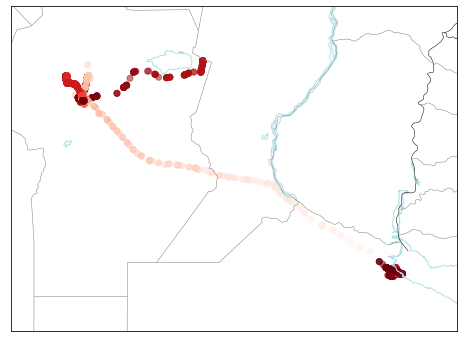

In [28]:
# se define las características del fondo del mapa
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cyl', resolution='h', 
            llcrnrlon= min_lons[0]-1, 
            llcrnrlat = min_lats[0]-1, 
            urcrnrlon = max_lons[0]+1, 
            urcrnrlat=max_lats[0]+1)
            
m.drawcoastlines(color='powderblue')
m.drawcountries(color='black')
m.drawstates(color='grey')

# graficar coordenadas, se usa el tiempo para darle el degradado (más claro, más temprano en el mes)
m.scatter(lons[1], lats[1], latlon=True,
          c=timestamp[1], 
          cmap='Reds', alpha=0.5)



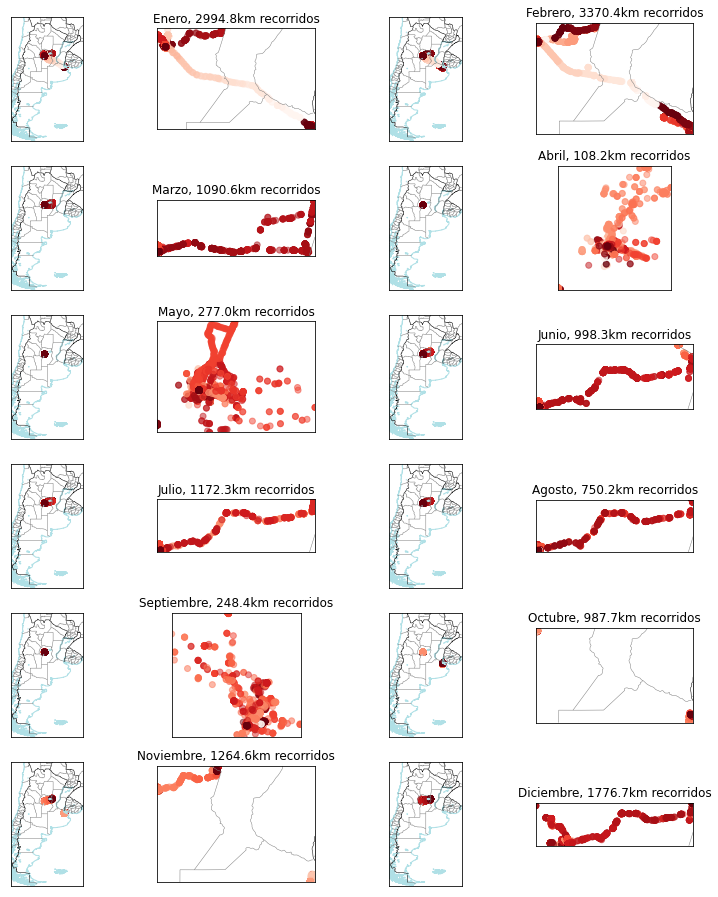

In [36]:
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']


fig = plt.figure(figsize=(13, 16))


for i in range (1, 13):
    if i < 2:
        j = i
    elif i < 3:
        j = i + 1
    elif i < 4:
        j = i + 2
    elif i < 5:
        j = i + 3
    elif i < 6:
        j = i + 4
    elif i < 7:
        j = i + 5
    elif i < 8:
        j = i + 6
    elif i < 9:
        j = i + 7
    elif i < 10:
        j = i + 8
    elif i < 11:
        j = i + 9
    elif i < 12:
        j = i + 10
    elif i < 13:
        j = i + 11
    
    ax = fig.add_subplot(6,4,j)
    #ax.set_title(f'{meses[i-1]}'+', '+f'{distancias_2020_list[i-1]}'+'km recorridos')
    map = Basemap(projection='cyl', resolution='h', 
                  llcrnrlon= -74, 
                  llcrnrlat = -56, 
                  urcrnrlon = -53, 
                  urcrnrlat=-20)
    
    #map.drawmapboundary(fill_color='aqua')
    #map.fillcontinents(color='coral',lake_color='aqua')
    map.drawcoastlines(color='powderblue')
    map.drawcountries(color='black')
    map.drawstates(color='grey')

    map.scatter(lons[i], lats[i], latlon=True,
                 c=timestamp[i], 
                 cmap='Reds', alpha=0.5)
    
    ax = fig.add_subplot(6,4,j+1)
    ax.set_title(f'{meses[i-1]}'+', '+f'{distancias_2020_list[i-1]}'+'km recorridos')
    map = Basemap(projection='cyl', resolution='h', 
                  llcrnrlon= min_lons[i-1], 
                  llcrnrlat = min_lats[i-1], 
                  urcrnrlon = max_lons[i-1], 
                  urcrnrlat=max_lats[i-1])
    
    #map.drawmapboundary(fill_color='aqua')
    #map.fillcontinents(color='coral',lake_color='aqua')
    #map.drawcoastlines(color='powderblue')
    map.drawcountries(color='black')
    map.drawstates(color='grey')

    map.scatter(lons[i], lats[i], latlon=True,
                 c=timestamp[i], 
                 cmap='Reds', alpha=0.5)
    


In [60]:
data_new_sort_2020.head()

,timestamp,latitude,longitude,accuracy,altitude,verticalAccuracy,velocity,heading,datetime,year,month,date,hour,value_accuracy,,timestampMs,activity_0_type,activity_0_confidence,activity_1_type,activity_1_confidence,activity_2_type,activity_2_confidence,activity_3_type,activity_3_confidence,activity_4_type,activity_4_confidence,activity_5_type,activity_5_confidence,activity_6_type,activity_6_confidence,activity_7_type,activity_7_confidence,activity_8_type,activity_8_confidence,activity_9_type,activity_9_confidence,activity_10_type,activity_10_confidence,activity_11_type,activity_11_confidence,datetime_activity,dist
1239487,1.577848e+09,-30.707562,-62.010781,26,-,-,-,-,2020-01-01 00:01:33.073,2020,1,2020-01-01,0,0,-,1.577848e+09,STILL,99,UNKNOWN,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2020-01-01 00:01:00.398000,0.0
1239488,1.577848e+09,-30.707562,-62.010781,26,-,-,-,-,2020-01-01 00:06:01.093,2020,1,2020-01-01,0,0,-,0.000000e+00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0.0
1239489,1.577848e+09,-30.707562,-62.010781,26,-,-,-,-,2020-01-01 00:09:36.431,2020,1,2020-01-01,0,0,-,1.577848e+09,STILL,100,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2020-01-01 00:09:44.148000,0.0
1239490,1.577848e+09,-30.707562,-62.010781,26,-,-,-,-,2020-01-01 00:11:01.446,2020,1,2020-01-01,0,0,-,1.577848e+09,STILL,90,ON_FOOT,7,WALKING,7,IN_VEHICLE,2,IN_RAIL_VEHICLE,2,IN_ROAD_VEHICLE,1,IN_FOUR_WHEELER_VEHICLE,1,IN_CAR,1,-,-,-,-,-,-,-,-,2020-01-01 00:11:00.383000,0.0
1239491,1.577849e+09,-30.707562,-62.010781,16,-,-,-,-,2020-01-01 00:19:44.679,2020,1,2020-01-01,0,0,-,0.000000e+00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0.0


In [62]:
total = data_new_sort_2020['dist'].sum()
print (total)

15039.32009510507


In [56]:
data_new_sort_2020 = data_new_sort_2020.fillna('-')

In [65]:


distancias_por_actividad_2020 = pd.pivot_table(data_new_sort_2020, 
                                    values=['dist'],
                                    index=['activity_0_type', 
                                           'activity_1_type', 
                                           'activity_2_type', 
                                           'activity_3_type', 
                                           'activity_4_type', 
                                           'activity_5_type',
                                           'activity_6_type', 
                                           'activity_7_type', 
                                           'activity_8_type', 
                                           'activity_9_type', 
                                           'activity_10_type', 
                                           'activity_11_type'], 
                                    #columns=['month'],
                                    aggfunc='sum')

distancias_por_actividad_2020 = distancias_por_actividad_2020.reset_index()

In [66]:
pd.set_option('display.max_rows', None)
distancias_por_actividad_2020_ord = distancias_por_actividad_2020.sort_values(by='dist', ascending=False)
distancias_por_actividad_2020_ord

,activity_0_type,activity_1_type,activity_2_type,activity_3_type,activity_4_type,activity_5_type,activity_6_type,activity_7_type,activity_8_type,activity_9_type,activity_10_type,activity_11_type,dist
0,-,-,-,-,-,-,-,-,-,-,-,-,3267.406111
2448,TILTING,-,-,-,-,-,-,-,-,-,-,-,3077.430234
2449,UNKNOWN,IN_VEHICLE,ON_BICYCLE,ON_FOOT,WALKING,RUNNING,STILL,IN_ROAD_VEHICLE,IN_RAIL_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,-,2648.515563
1989,STILL,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_RAIL_VEHICLE,ON_FOOT,WALKING,UNKNOWN,-,-,-,640.088232
140,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_BUS,IN_RAIL_VEHICLE,STILL,UNKNOWN,-,-,-,-,370.051825
238,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_BUS,UNKNOWN,IN_RAIL_VEHICLE,-,-,-,-,-,367.256358
1914,STILL,-,-,-,-,-,-,-,-,-,-,-,253.254398
145,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_BUS,IN_RAIL_VEHICLE,UNKNOWN,-,-,-,-,-,225.036081
1073,ON_BICYCLE,-,-,-,-,-,-,-,-,-,-,-,224.176770
183,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_BUS,IN_TWO_WHEELER_VEHICLE,UNKNOWN,IN_RAIL_VEHICLE,-,-,-,-,164.096834


In [67]:
total_km_2020_act=distancias_por_actividad_2020['dist'].sum()
print (total_km_2020_act)

15039.32009510504


In [84]:
dict_act = {}
for i in range (0,11):
    list_act=distancias_por_actividad_2020_ord['activity_'+str(i)+'_type'].unique().tolist()
    dict_act[i]=list_act

In [85]:
list_all_act = dict_act[0]

for i in range (1, 11):
    list_all_act = list_all_act+dict_act[i]

In [87]:
list_all_act_uni= [] 
[list_all_act_uni.append(x) for x in list_all_act if x not in list_all_act_uni] 
list_all_act_uni

['-',
 'TILTING',
 'UNKNOWN',
 'STILL',
 'IN_VEHICLE',
 'ON_BICYCLE',
 'ON_FOOT',
 'EXITING_VEHICLE',
 'IN_ROAD_VEHICLE',
 'IN_RAIL_VEHICLE',
 'WALKING',
 'RUNNING',
 'IN_FOUR_WHEELER_VEHICLE',
 'IN_TWO_WHEELER_VEHICLE',
 'IN_CAR',
 'IN_BUS']

In [88]:
reemplazos_act = ['-', 
                  'Tilting', 
                  'Unknown', 
                  'Still', 
                  'Car/Bus', 
                  'Bike', 
                  'On_Foot', 
                  'Car/Bus', 
                  'Car/Bus', 
                  'Car/Bus', 
                  'On_Foot',
                  'On_Foot',
                  'Car/Bus', 
                  'Bike',
                  'Car/Bus',
                  'Car/Bus']

act_reemp = pd.DataFrame(list(zip(list_all_act_uni, reemplazos_act)), columns =['viejo', 'nuevo']) 

In [90]:
distancias_por_actividad_2020_ord_2 = distancias_por_actividad_2020_ord.replace(list_all_act_uni, reemplazos_act)

In [91]:
distancias_por_actividad_2020_ord_2.head()

,activity_0_type,activity_1_type,activity_2_type,activity_3_type,activity_4_type,activity_5_type,activity_6_type,activity_7_type,activity_8_type,activity_9_type,activity_10_type,activity_11_type,dist
0,-,-,-,-,-,-,-,-,-,-,-,-,3267.406111
2448,Tilting,-,-,-,-,-,-,-,-,-,-,-,3077.430234
2449,Unknown,Car/Bus,Bike,On_Foot,On_Foot,On_Foot,Still,Car/Bus,Car/Bus,Car/Bus,Car/Bus,-,2648.515563
1989,Still,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,On_Foot,On_Foot,Unknown,-,-,-,640.088232
140,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Still,Unknown,-,-,-,-,370.051825


In [94]:
distancias_por_actividad_2020_ord_2.mode(axis=1)

,0,1
0,-,NaN
2448,-,NaN
2449,Car/Bus,NaN
1989,Car/Bus,NaN
140,Car/Bus,NaN
238,Car/Bus,NaN
1914,-,NaN
145,Car/Bus,NaN
1073,-,NaN
183,Car/Bus,NaN


In [50]:
#se generan dataframes individuales por año, eliminando los valores malos de precisión 
#se genera una tabla de distancias por mes

data_2020=data[data['year']==2020] 
data_2020 = data_2020[data_2020['value_accuracy']=='0']

año_2020_dict ={}

for i in range (1,13):
    año_2020_dict[i] = data_2020[data_2020['month'] == i]

distancias_por_mes_2020 = pd.pivot_table(data_2020, 
                                    values=['dist'],
                                    index=['month'], 
                                    #columns=['banco'],
                                    aggfunc='sum')

print(distancias_por_mes_2020)
print ('total: ', distancias_por_mes_2020['dist'].sum())

              dist
month             
1      2109.849536
2      2311.296798
3       614.774814
4       108.204370
5       276.702450
6       474.680945
7       762.637423
8       328.761583
9       248.393505
10      985.000269
11      996.304429
12      667.700013
total:  9884.306134436698


In [ ]:
#se grafican todos los puntos de coordenadas de un año

plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(data_2020['longitude'], data_2020['latitude'], c=data_2020['month'], cmap = 'rainbow')
plt.xlim(-67,-57)
plt.ylim(-36, -29)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

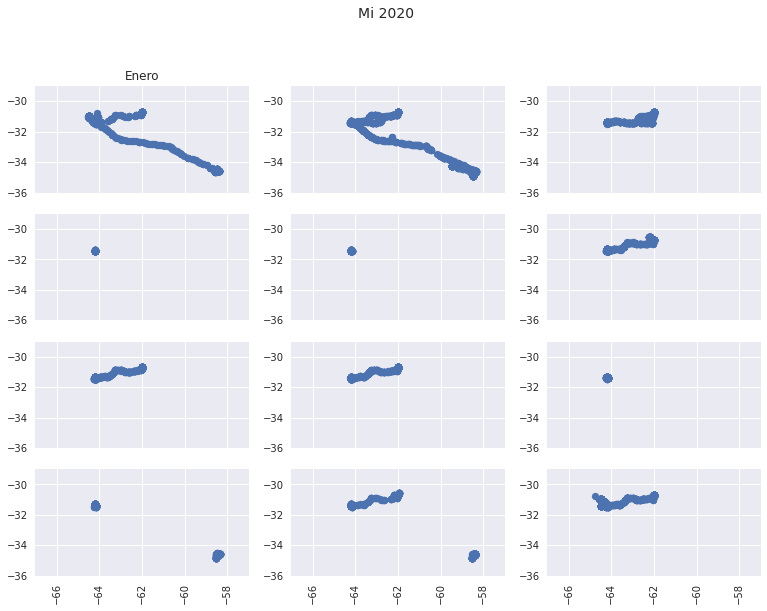

In [35]:
#se grafican todos los puntos de coordenadas de un año por mes
with plt.style.context('seaborn'):
    fig, axs = plt.subplots(4,3)
    fig.autofmt_xdate(rotation=90, ha="center")
    fig.set_size_inches(13, 10)
    fig.suptitle('Mi 2020', fontsize=14, va='center')

    l1 = axs[0,0].scatter(año_2020_dict[1]['longitude'], año_2020_dict[1]['latitude'])
    axs[0,0].set_xlim([-67,-57])
    axs[0,0].set_ylim([-36, -29])
    axs[0,0].set_title(f'Enero')
    l2 = axs[0,1].scatter(año_2020_dict[2]['longitude'], año_2020_dict[2]['latitude'])
    axs[0,1].set_xlim([-67,-57])
    axs[0,1].set_ylim([-36, -29])
    l3 = axs[0,2].scatter(año_2020_dict[3]['longitude'], año_2020_dict[3]['latitude'])
    axs[0,2].set_xlim([-67,-57])
    axs[0,2].set_ylim([-36, -29])
    l4 = axs[1,0].scatter(año_2020_dict[4]['longitude'], año_2020_dict[4]['latitude'])
    axs[1,0].set_xlim([-67,-57])
    axs[1,0].set_ylim([-36, -29])
    l5 = axs[1,1].scatter(año_2020_dict[5]['longitude'], año_2020_dict[5]['latitude'])
    axs[1,1].set_xlim([-67,-57])
    axs[1,1].set_ylim([-36, -29])
    l6 = axs[1,2].scatter(año_2020_dict[6]['longitude'], año_2020_dict[6]['latitude'])
    axs[1,2].set_xlim([-67,-57])
    axs[1,2].set_ylim([-36, -29])
    l7 = axs[2,0].scatter(año_2020_dict[7]['longitude'], año_2020_dict[7]['latitude'])
    axs[2,0].set_xlim([-67,-57])
    axs[2,0].set_ylim([-36, -29])
    l8 = axs[2,1].scatter(año_2020_dict[8]['longitude'], año_2020_dict[8]['latitude'])
    axs[2,1].set_xlim([-67,-57])
    axs[2,1].set_ylim([-36, -29])
    l9 = axs[2,2].scatter(año_2020_dict[9]['longitude'], año_2020_dict[9]['latitude'])
    axs[2,2].set_xlim([-67,-57])
    axs[2,2].set_ylim([-36, -29])
    l10 = axs[3,0].scatter(año_2020_dict[10]['longitude'], año_2020_dict[10]['latitude'])
    axs[3,0].set_xlim([-67,-57])
    axs[3,0].set_ylim([-36, -29])
    l11 = axs[3,1].scatter(año_2020_dict[11]['longitude'], año_2020_dict[11]['latitude'])
    axs[3,1].set_xlim([-67,-57])
    axs[3,1].set_ylim([-36, -29])
    l12 = axs[3,2].scatter(año_2020_dict[12]['longitude'], año_2020_dict[12]['latitude'])
    axs[3,2].set_xlim([-67,-57])
    axs[3,2].set_ylim([-36, -29])